# Workflow Outline
This notebook outlines the workflow for finetuning emotion detection. It should be ran in Google Colab with a GPU

## Install & Import modules

In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.7 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn as nn
import transformers
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os
import copy
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


## Import data

In [3]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

## Set up data pipeline

In [5]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
EBAT_filename = "EmoBank_AffectiveText.csv"
CHILDREN_filename = "children_lex.csv"
EMOBANK_filename = "emobank.csv"

df_children = pd.read_csv(os.path.join(CLEAN_DATA_DIR, CHILDREN_filename))
df_emobank = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EMOBANK_filename))
df = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EBAT_filename))

print(f'Children story dataset: {len(df_children)}')
print(f'Emobank dataset: {len(df_emobank)}')
df_children.head()

Children story dataset: 14024
Emobank dataset: 9814


,author,story,annotator_1,annotator_2,sentence,VADER_neg,VADER_neu,VADER_pos,VADER_compound,TextBlob_polarity,TextBlob_subjectivity,AFINN
0,Grimms,106_the_poor_millers_boy_and_the_cat,N:N,N:N,In a certain mill lived an old miller who had ...,0.000,0.896,0.104,0.2732,0.157143,0.385714,1.0
1,Grimms,106_the_poor_millers_boy_and_the_cat,N:N,N:N,"As they had been with him several years, he on...",0.000,0.859,0.141,0.8271,0.366667,0.166667,4.0
2,Grimms,106_the_poor_millers_boy_and_the_cat,N:D,N:D,"The third of the boys was, however, the drudge...",0.065,0.935,0.000,-0.2732,0.000000,0.000000,-2.0
3,Grimms,106_the_poor_millers_boy_and_the_cat,N:N,N:D,"Then all three went out together, and when the...",0.086,0.861,0.053,-0.3182,-0.425000,0.700000,-2.0
4,Grimms,106_the_poor_millers_boy_and_the_cat,N:N,N:N,"Hans, however, went with them, and when it was...",0.000,1.000,0.000,0.0000,-0.155556,0.288889,0.0


In [ ]:
# some global variables 
EKMAN_EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
VAD_EMOTIONS = ['V', 'A', 'D']

EMOTION_NAMES = ['Ekman', 'VAD']
EMOTION_DIMS = [6, 3]

# Load data into numpy
x_text_raw = list(df['text'])
y_ekman_raw = df[EKMAN_EMOTIONS].to_numpy()
y_vad_raw = df[VAD_EMOTIONS].to_numpy()

# Example:
print(x_text_raw[0])
print(y_ekman_raw[0])
print(y_vad_raw[0])
print(len(x_text_raw))

Mortar assault leaves at least 18 dead
[22  2 60  0 64  0]
[2.29 3.29 2.86]
1149


In [ ]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 
# Note: 'bert-base-uncased' is the name of the checkpoint, this should be consistent in both the tokenizer and the AutoModel

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

encoded_input = tokenizer(x_text_raw, padding=True, truncation=True, return_tensors="pt")
# Note: padding matches the length of each row, truncation makes sure that the input length isn't too long for the model (256 for bert-base-uncased)

print(encoded_input.keys())
# Note: the keys we want are input_ids and ateention_mask, token_type_ids is for tasks where you want two sequences as input (e.g. Q&A)

print(encoded_input['input_ids'].shape) 
# Note: the width defaults to the longest sentence in our data

# Example:
print(tokenizer.decode(encoded_input["input_ids"][0])) # you can decode it back into text

X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']

y_ekman_tensor = torch.tensor(y_ekman_raw, dtype=torch.float)
y_vad_tensor = torch.tensor(y_vad_raw, dtype=torch.float)

# optional: delete df and x_text if the dataset is large

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([1149, 21])
[CLS] mortar assault leaves at least 18 dead [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
# Normalizing y (subject to change)
y_ekman_tensor = F.normalize(y_ekman_tensor, dim=-1)
y_vad_tensor = y_vad_tensor - 3
# VAD could be squished into [0, 1] if needed?
# y_vad_tensor = (y_vad_tensor - 3) * 2 - 1

y = torch.concat((y_ekman_tensor, y_vad_tensor), axis=-1)


### Train-val-test split

* split data set into 80-20 train-test
* split train into 50-50 labelling schemes


In [ ]:
def train_val_split(X_ids, X_mask, y, ratio):
  n = X_ids.shape[0]

  perm = torch.randperm(n)

  train_size = int(ratio * n)

  X_ids_train, X_mask_train, y_train = X_ids[perm[:train_size]], X_mask[perm[:train_size]], y[perm[:train_size]]
  X_ids_val, X_mask_val, y_val = X_ids[perm[train_size:]], X_mask[perm[train_size:]], y[perm[train_size:]]

  return X_ids_train, X_mask_train, y_train, X_ids_val, X_mask_val, y_val

In [ ]:
# split into train-val
X_ids_train, X_mask_train, y_train, X_ids_test, X_mask_test, y_test = train_val_split(X_input, X_mask, y, ratio=0.8)

# split into two tasks (this is very redundant but makes workflow clearer)
X_ids_ekman, X_mask_ekman, y_ekman, X_ids_vad, X_mask_vad, y_vad = train_val_split(X_ids_train, X_mask_train, y_train, ratio=0.5)

# drop the redundant labels
y_ekman[:, 6:] = torch.zeros_like(y_ekman[:, 6:])
y_vad[:, :6] = torch.zeros_like(y_vad[:, :6])

In [ ]:
print(f'number of ekman training points: {len(X_ids_ekman)}')
print(f'number of vad training points: {len(X_ids_vad)}')

number of ekman training points: 459
number of vad training points: 460


In [ ]:
# attach task labels to the two tasks 
task_ekman = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ids_ekman), 1))
task_vad = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_ids_vad), 1))
task_test = torch.tensor([1, 1]).unsqueeze(0).repeat((len(X_ids_test), 1))

# merge ekman and vad back into one train set 
X_ids_train = torch.concat((X_ids_ekman, X_ids_vad), dim=0)
X_mask_train = torch.concat((X_mask_ekman, X_mask_vad), dim=0)
y_train = torch.concat((y_ekman, y_vad), dim=0)
task_train = torch.concat((task_ekman, task_vad), dim=0)

# Example
id = 600
# print(X_ids_train[id])
# print(X_mask_train[id])
print(y_train[id])
print(task_train[id])

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4400,  0.6700,
        -0.3300])
tensor([0, 1])


In [ ]:
# Move everything to device
X_ids_train = X_ids_train.to(DEVICE)
X_mask_train = X_mask_train.to(DEVICE)
y_train = y_train.to(DEVICE)
task_train = task_train.to(DEVICE)

X_ids_test = X_ids_test.to(DEVICE)
X_mask_test = X_mask_test.to(DEVICE)
y_test = y_test.to(DEVICE)
task_test = task_test.to(DEVICE)

### Dataset

In [ ]:
class EBAT_dataset(Dataset):
  def __init__(self, X_ids, X_mask, y, task, transform=None):
    self.X_ids = X_ids 
    self.X_mask = X_mask
    self.y = y # [0.4, 0.4, 0.2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.1, 0.4, 0.1, 0.2, 0.1, 0.1]
    self.task = task # [[1, 0], [0, 1]]
    self.transform = transform

  def __len__(self):
    return self.X_ids.shape[0]

  def __getitem__(self, idx):
    sample = (self.X_ids[idx], self.X_mask[idx], self.y[idx], self.task[idx])
    if self.transform:
        sample = self.transform(sample)
    return sample


In [ ]:
train_dataset = EBAT_dataset(X_ids_train, X_mask_train, y_train, task_train)
test_dataset = EBAT_dataset(X_ids_test, X_mask_test, y_test, task_test)

print(f'total data = {len(X_input)}')
print(f'train set size = {len(train_dataset)}')
print(f'test set size = {len(test_dataset)}')

total data = 1149
train set size = 919
test set size = 230


### DataLoader

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 10, shuffle=True)

print(f'number of batches in training set: {len(train_dataloader)}')
print(f'number of batches in testing set: {len(test_dataloader)}')

# example batch
sample = next(iter(train_dataloader))
X_id, X_mask, y, task = sample

# example single data
print(X_id[0])
print(X_mask[0])
print(y[0])
print(task[0])

number of batches in training set: 92
number of batches in testing set: 23
tensor([  101,  2726,  5660,  2000, 13590,  2007,  2026,  6494, 15985,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1000,
         0.0000], device='cuda:0')
tensor([0, 1], device='cuda:0')


## Model Definition

In [ ]:
class MultiheadNetwork(nn.Module):
  def __init__(self, baseModel):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    self.ekman_predictor = nn.Linear(768, EMOTION_DIMS[0])
    self.vad_predictor = nn.Linear(768, EMOTION_DIMS[1])

    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    # print(hidden_state.shape)
    # print(pooler_output.shape)
    # print(task[:, 0].shape)
    # print(task[:, 0].unsqueeze(-1).shape)
    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(pooler_output)
    y_ekman = self.relu(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(pooler_output)
    y_vad = self.relu(y_vad)

    y = torch.concat((y_ekman, y_vad), dim=1)

    return y

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
net = MultiheadNetwork(bert)
net.to(DEVICE)

print(f'moved network to {DEVICE}')

moved network to cuda:0


In [ ]:
print([m.numel() for m in net.parameters() if m.requires_grad==True])

[4608, 6, 2304, 3]


In [ ]:
with torch.no_grad():
  sample = next(iter(train_dataloader))
  X_id, X_mask, y, task = sample

  y_pred = net(X_id, X_mask, task)

### Loss Function

In [ ]:
class custom_MSE(object):
  def __init__(self):
    self.loss = nn.MSELoss()
    pass
  
  def __call__(self, y_gt, y_pred) -> torch.tensor:
    '''
    Computes MSE on all emotion labelling schemes

    Returns:
    -----
    losses: 1D tensor with length num_schemes
    '''
    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float)
    s = 0
    for (i, dim) in enumerate(EMOTION_DIMS):
      losses[i] = self.loss(y_gt[:, s:s+dim], y_pred[:, s:s+dim]).mean()
      s += dim
    # avg_loss = torch.norm(losses)
    return losses


# def custom_MSE(y_gt, y_pred, task) -> torch.tensor:
#   '''
#   Computes MSE on all emotion labelling schemes

#   Returns:
#   -----
#   losses: 1D tensor with length num_schemes
#   '''
#   losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float())
#   s = 0
#   for (i, dim) in enumerate(EMOTION_DIMS):
#     toggle = task[i]
#     losses[i] = nn.MSELoss(y_gt[s:s+dim], y_pred[s:s+dim]) * toggle
#     s += dim
#   # avg_loss = torch.norm(losses)
#   return losses

## Training Loop

In [ ]:
class TrainingManager():
  def __init__(self, net, train_dataloader, test_dataloader, max_epochs=100):
    self.net = net
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    # self.criterion = nn.MSELoss()
    self.criterion = custom_MSE()

    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-6)

    self.history = {
        'train_loss_ekman': [],
        'train_loss_vad': [],
        'train_loss_avg': [],
        'test_loss_ekman': [],
        'test_loss_vad': [],
        'test_loss_avg': [],
        'test_ekman_accuracy': []
    }

    self.max_epochs = max_epochs
    self.num_epochs = 0
  
  def train(self, epochs):
    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_avg = 0
      ekman_count = 0
      vad_count = 0

      for X_id, X_mask, y, task in tqdm(self.train_dataloader):
        self.optimizer.zero_grad()

        y_pred = net(X_id, X_mask, task)

        train_loss = self.criterion(y_pred, y)
        loss = torch.norm(train_loss)

        loss.backward()

        self.optimizer.step()

        # storing minibatch results
        total_loss_ekman += train_loss[0].item()
        total_loss_vad += train_loss[1].item()
        total_loss_avg += torch.norm(train_loss).item()

        ekman_count += task[:, 0].sum()
        vad_count += task[:, 1].sum()

      # storing epoch results
      test_loss_ekman, test_loss_vad, test_loss_avg, test_ekman_accuracy = self.evaluate(self.test_dataloader)

      total_loss_ekman /= len(self.train_dataloader)
      total_loss_vad /= len(self.train_dataloader)
      total_loss_avg /= len(self.train_dataloader)
    
      self.history['train_loss_ekman'].append(total_loss_ekman)
      self.history['train_loss_vad'].append(total_loss_vad)
      self.history['train_loss_avg'].append(total_loss_avg)
      self.history['test_loss_ekman'].append(test_loss_ekman)
      self.history['test_loss_vad'].append(test_loss_vad)
      self.history['test_loss_avg'].append(test_loss_avg)
      self.history['test_ekman_accuracy'].append(test_ekman_accuracy)

      print(f'Epoch {e+1}: train_loss = {total_loss_avg:.3f}, test_loss = {test_loss_avg:.3f}')
      print(f'Epoch {e+1}: train_ekman = {total_loss_ekman:.3f}, train_vad = {total_loss_vad:.3f}')
      print(f'Epoch {e+1}: test_ekman = {test_loss_ekman:.3f}, test_vad = {test_loss_vad:.3f}')
      print(f'Epoch {e+1}: test_ekman_accuracy = {test_ekman_accuracy:.3f}')

      self.num_epochs += 1
  
  def evaluate(self, dataloader=None):
    if dataloader == None:
      dataloader = self.test_dataloader
    with torch.no_grad():
      total_loss_avg = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      for X_id, X_mask, y, task in tqdm(dataloader):
        y_pred = net(X_id, X_mask, task)
        loss = self.criterion(y_pred, y)

        y_top = torch.argmax(y[:, 0: 6], dim=-1)
        y_top_pred = torch.argmax(y_pred[:, 0:6], dim=-1)

        ekman_top1_correct += torch.where(y_top == y_top_pred, torch.ones_like(y_top), torch.zeros_like(y_top)).sum()

        total_loss_ekman += loss[0].item()
        total_loss_vad += loss[1].item()
        total_loss_avg += torch.norm(loss).item()
    
    total_loss_ekman /= len(dataloader)
    total_loss_vad /= len(dataloader)
    total_loss_avg /= len(dataloader)
    ekman_accuracy = ekman_top1_correct.item() / len(dataloader.dataset)

    return total_loss_ekman, total_loss_vad, total_loss_avg, ekman_accuracy

  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Avg loss')
    plt.plot(self.history['train_loss_avg'], label='train')
    plt.plot(self.history['test_loss_avg'], label='test')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Ekman Loss')
    plt.plot(self.history['train_loss_ekman'], label='train')
    plt.plot(self.history['test_loss_ekman'], label='test')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('VAD Loss')
    plt.plot(self.history['train_loss_vad'], label='train')
    plt.plot(self.history['test_loss_vad'], label='test')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('Ekman top1 Accuracy')
    plt.plot(self.history['test_ekman_accuracy'], label='test')
    plt.legend()

    plt.show()


net = MultiheadNetwork(bert)
net.to(DEVICE)
training_manager = TrainingManager(net, train_dataloader, test_dataloader)


In [ ]:
training_manager.evaluate()

  0%|          | 0/23 [00:00<?, ?it/s]

(0.1730782687664032,
 0.10514531883856525,
 0.20603692272435065,
 0.1391304347826087)

In [ ]:
training_manager.train(epochs=50)

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1: train_loss = 0.141, test_loss = 0.195
Epoch 1: train_ekman = 0.137, train_vad = 0.023
Epoch 1: test_ekman = 0.163, test_vad = 0.103
Epoch 1: test_ekman_accuracy = 0.139


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2: train_loss = 0.133, test_loss = 0.187
Epoch 2: train_ekman = 0.129, train_vad = 0.023
Epoch 2: test_ekman = 0.154, test_vad = 0.101
Epoch 2: test_ekman_accuracy = 0.139


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3: train_loss = 0.127, test_loss = 0.180
Epoch 3: train_ekman = 0.122, train_vad = 0.022
Epoch 3: test_ekman = 0.146, test_vad = 0.101
Epoch 3: test_ekman_accuracy = 0.139


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4: train_loss = 0.122, test_loss = 0.174
Epoch 4: train_ekman = 0.116, train_vad = 0.022
Epoch 4: test_ekman = 0.139, test_vad = 0.100
Epoch 4: test_ekman_accuracy = 0.139


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5: train_loss = 0.117, test_loss = 0.168
Epoch 5: train_ekman = 0.111, train_vad = 0.022
Epoch 5: test_ekman = 0.134, test_vad = 0.099
Epoch 5: test_ekman_accuracy = 0.139


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6: train_loss = 0.113, test_loss = 0.166
Epoch 6: train_ekman = 0.107, train_vad = 0.022
Epoch 6: test_ekman = 0.129, test_vad = 0.098
Epoch 6: test_ekman_accuracy = 0.143


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7: train_loss = 0.109, test_loss = 0.161
Epoch 7: train_ekman = 0.104, train_vad = 0.022
Epoch 7: test_ekman = 0.126, test_vad = 0.098
Epoch 7: test_ekman_accuracy = 0.143


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8: train_loss = 0.107, test_loss = 0.159
Epoch 8: train_ekman = 0.101, train_vad = 0.022
Epoch 8: test_ekman = 0.123, test_vad = 0.098
Epoch 8: test_ekman_accuracy = 0.152


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9: train_loss = 0.104, test_loss = 0.157
Epoch 9: train_ekman = 0.099, train_vad = 0.022
Epoch 9: test_ekman = 0.120, test_vad = 0.097
Epoch 9: test_ekman_accuracy = 0.148


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10: train_loss = 0.102, test_loss = 0.155
Epoch 10: train_ekman = 0.097, train_vad = 0.022
Epoch 10: test_ekman = 0.118, test_vad = 0.097
Epoch 10: test_ekman_accuracy = 0.152


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11: train_loss = 0.100, test_loss = 0.153
Epoch 11: train_ekman = 0.095, train_vad = 0.022
Epoch 11: test_ekman = 0.116, test_vad = 0.097
Epoch 11: test_ekman_accuracy = 0.148


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12: train_loss = 0.099, test_loss = 0.152
Epoch 12: train_ekman = 0.094, train_vad = 0.022
Epoch 12: test_ekman = 0.114, test_vad = 0.097
Epoch 12: test_ekman_accuracy = 0.161


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13: train_loss = 0.098, test_loss = 0.151
Epoch 13: train_ekman = 0.092, train_vad = 0.021
Epoch 13: test_ekman = 0.112, test_vad = 0.097
Epoch 13: test_ekman_accuracy = 0.178


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14: train_loss = 0.096, test_loss = 0.149
Epoch 14: train_ekman = 0.091, train_vad = 0.021
Epoch 14: test_ekman = 0.110, test_vad = 0.097
Epoch 14: test_ekman_accuracy = 0.187


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 15: train_loss = 0.094, test_loss = 0.144
Epoch 15: train_ekman = 0.088, train_vad = 0.021
Epoch 15: test_ekman = 0.104, test_vad = 0.096
Epoch 15: test_ekman_accuracy = 0.204


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 16: train_loss = 0.088, test_loss = 0.140
Epoch 16: train_ekman = 0.082, train_vad = 0.021
Epoch 16: test_ekman = 0.098, test_vad = 0.096
Epoch 16: test_ekman_accuracy = 0.222


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 17: train_loss = 0.084, test_loss = 0.138
Epoch 17: train_ekman = 0.078, train_vad = 0.021
Epoch 17: test_ekman = 0.095, test_vad = 0.096
Epoch 17: test_ekman_accuracy = 0.252


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 18: train_loss = 0.083, test_loss = 0.138
Epoch 18: train_ekman = 0.076, train_vad = 0.021
Epoch 18: test_ekman = 0.094, test_vad = 0.096
Epoch 18: test_ekman_accuracy = 0.261


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 19: train_loss = 0.081, test_loss = 0.135
Epoch 19: train_ekman = 0.075, train_vad = 0.021
Epoch 19: test_ekman = 0.093, test_vad = 0.096
Epoch 19: test_ekman_accuracy = 0.270


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 20: train_loss = 0.080, test_loss = 0.135
Epoch 20: train_ekman = 0.074, train_vad = 0.021
Epoch 20: test_ekman = 0.092, test_vad = 0.096
Epoch 20: test_ekman_accuracy = 0.265


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 21: train_loss = 0.080, test_loss = 0.136
Epoch 21: train_ekman = 0.074, train_vad = 0.021
Epoch 21: test_ekman = 0.092, test_vad = 0.096
Epoch 21: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 22: train_loss = 0.080, test_loss = 0.135
Epoch 22: train_ekman = 0.074, train_vad = 0.021
Epoch 22: test_ekman = 0.092, test_vad = 0.096
Epoch 22: test_ekman_accuracy = 0.252


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 23: train_loss = 0.079, test_loss = 0.134
Epoch 23: train_ekman = 0.073, train_vad = 0.021
Epoch 23: test_ekman = 0.091, test_vad = 0.096
Epoch 23: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 24: train_loss = 0.080, test_loss = 0.136
Epoch 24: train_ekman = 0.073, train_vad = 0.021
Epoch 24: test_ekman = 0.091, test_vad = 0.096
Epoch 24: test_ekman_accuracy = 0.265


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 25: train_loss = 0.079, test_loss = 0.134
Epoch 25: train_ekman = 0.073, train_vad = 0.021
Epoch 25: test_ekman = 0.091, test_vad = 0.096
Epoch 25: test_ekman_accuracy = 0.252


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 26: train_loss = 0.080, test_loss = 0.135
Epoch 26: train_ekman = 0.073, train_vad = 0.021
Epoch 26: test_ekman = 0.091, test_vad = 0.096
Epoch 26: test_ekman_accuracy = 0.248


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 27: train_loss = 0.079, test_loss = 0.134
Epoch 27: train_ekman = 0.073, train_vad = 0.021
Epoch 27: test_ekman = 0.091, test_vad = 0.096
Epoch 27: test_ekman_accuracy = 0.252


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 28: train_loss = 0.079, test_loss = 0.134
Epoch 28: train_ekman = 0.072, train_vad = 0.021
Epoch 28: test_ekman = 0.091, test_vad = 0.096
Epoch 28: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 29: train_loss = 0.079, test_loss = 0.134
Epoch 29: train_ekman = 0.072, train_vad = 0.021
Epoch 29: test_ekman = 0.090, test_vad = 0.096
Epoch 29: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 30: train_loss = 0.079, test_loss = 0.133
Epoch 30: train_ekman = 0.072, train_vad = 0.021
Epoch 30: test_ekman = 0.090, test_vad = 0.096
Epoch 30: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 31: train_loss = 0.078, test_loss = 0.134
Epoch 31: train_ekman = 0.072, train_vad = 0.021
Epoch 31: test_ekman = 0.090, test_vad = 0.096
Epoch 31: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 32: train_loss = 0.078, test_loss = 0.133
Epoch 32: train_ekman = 0.072, train_vad = 0.021
Epoch 32: test_ekman = 0.090, test_vad = 0.096
Epoch 32: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 33: train_loss = 0.078, test_loss = 0.133
Epoch 33: train_ekman = 0.072, train_vad = 0.021
Epoch 33: test_ekman = 0.090, test_vad = 0.096
Epoch 33: test_ekman_accuracy = 0.252


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 34: train_loss = 0.078, test_loss = 0.133
Epoch 34: train_ekman = 0.072, train_vad = 0.021
Epoch 34: test_ekman = 0.090, test_vad = 0.096
Epoch 34: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 35: train_loss = 0.078, test_loss = 0.134
Epoch 35: train_ekman = 0.071, train_vad = 0.021
Epoch 35: test_ekman = 0.090, test_vad = 0.096
Epoch 35: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 36: train_loss = 0.078, test_loss = 0.133
Epoch 36: train_ekman = 0.071, train_vad = 0.021
Epoch 36: test_ekman = 0.090, test_vad = 0.096
Epoch 36: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 37: train_loss = 0.077, test_loss = 0.132
Epoch 37: train_ekman = 0.071, train_vad = 0.021
Epoch 37: test_ekman = 0.090, test_vad = 0.096
Epoch 37: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 38: train_loss = 0.077, test_loss = 0.132
Epoch 38: train_ekman = 0.071, train_vad = 0.021
Epoch 38: test_ekman = 0.089, test_vad = 0.096
Epoch 38: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 39: train_loss = 0.078, test_loss = 0.132
Epoch 39: train_ekman = 0.071, train_vad = 0.021
Epoch 39: test_ekman = 0.089, test_vad = 0.096
Epoch 39: test_ekman_accuracy = 0.270


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 40: train_loss = 0.077, test_loss = 0.133
Epoch 40: train_ekman = 0.071, train_vad = 0.021
Epoch 40: test_ekman = 0.089, test_vad = 0.095
Epoch 40: test_ekman_accuracy = 0.265


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 41: train_loss = 0.078, test_loss = 0.134
Epoch 41: train_ekman = 0.071, train_vad = 0.021
Epoch 41: test_ekman = 0.089, test_vad = 0.095
Epoch 41: test_ekman_accuracy = 0.257


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 42: train_loss = 0.077, test_loss = 0.132
Epoch 42: train_ekman = 0.071, train_vad = 0.021
Epoch 42: test_ekman = 0.089, test_vad = 0.095
Epoch 42: test_ekman_accuracy = 0.278


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 43: train_loss = 0.076, test_loss = 0.132
Epoch 43: train_ekman = 0.071, train_vad = 0.021
Epoch 43: test_ekman = 0.089, test_vad = 0.095
Epoch 43: test_ekman_accuracy = 0.270


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 44: train_loss = 0.077, test_loss = 0.132
Epoch 44: train_ekman = 0.071, train_vad = 0.021
Epoch 44: test_ekman = 0.089, test_vad = 0.095
Epoch 44: test_ekman_accuracy = 0.270


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 45: train_loss = 0.076, test_loss = 0.132
Epoch 45: train_ekman = 0.070, train_vad = 0.021
Epoch 45: test_ekman = 0.089, test_vad = 0.095
Epoch 45: test_ekman_accuracy = 0.278


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 46: train_loss = 0.076, test_loss = 0.132
Epoch 46: train_ekman = 0.070, train_vad = 0.021
Epoch 46: test_ekman = 0.089, test_vad = 0.095
Epoch 46: test_ekman_accuracy = 0.270


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 47: train_loss = 0.077, test_loss = 0.133
Epoch 47: train_ekman = 0.070, train_vad = 0.021
Epoch 47: test_ekman = 0.089, test_vad = 0.095
Epoch 47: test_ekman_accuracy = 0.278


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 48: train_loss = 0.077, test_loss = 0.133
Epoch 48: train_ekman = 0.070, train_vad = 0.021
Epoch 48: test_ekman = 0.089, test_vad = 0.095
Epoch 48: test_ekman_accuracy = 0.261


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 49: train_loss = 0.076, test_loss = 0.132
Epoch 49: train_ekman = 0.070, train_vad = 0.021
Epoch 49: test_ekman = 0.088, test_vad = 0.095
Epoch 49: test_ekman_accuracy = 0.265


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 50: train_loss = 0.077, test_loss = 0.132
Epoch 50: train_ekman = 0.070, train_vad = 0.021
Epoch 50: test_ekman = 0.088, test_vad = 0.095
Epoch 50: test_ekman_accuracy = 0.261


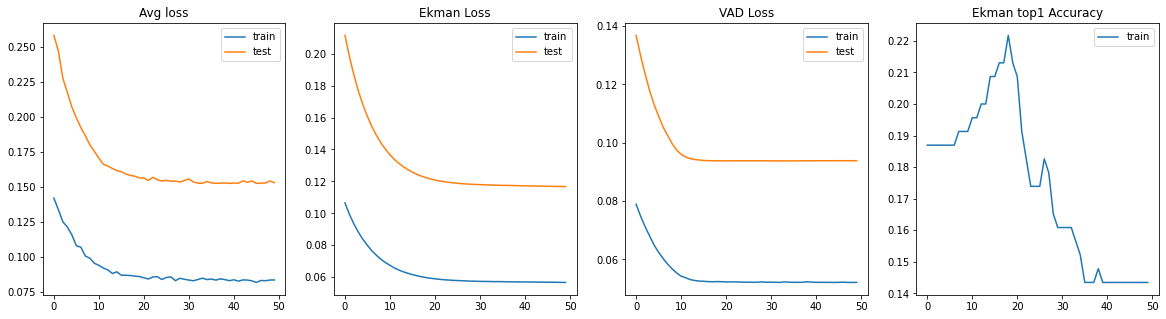

In [ ]:
# 50-50 data split
training_manager.plot_history()

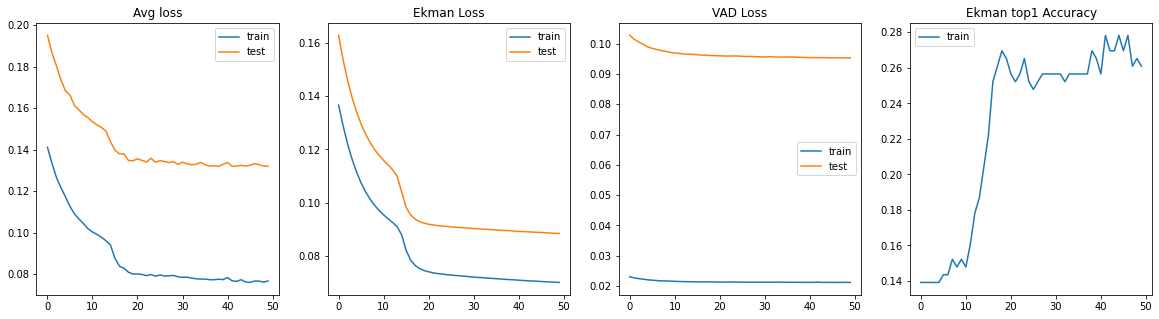

In [ ]:
training_manager.plot_history()

## Qualitative Evaluation

In [ ]:
results_df = pd.DataFrame([], columns = EKMAN_EMOTIONS + VAD_EMOTIONS)
with torch.no_grad():
  sample = next(iter(test_dataloader))
  X_id, X_mask, y, task = sample
  y_pred = net(X_id, X_mask, task)
  

  for i in range(len(X_id)):
    sent = tokenizer.decode(X_id[i], skip_special_tokens=True)
    row_gt = {heading: val for heading, val, in zip(results_df.columns, y[i].cpu().numpy())}
    row_pred = {heading: val for heading, val, in zip(results_df.columns, y_pred[i].cpu().numpy())}
    results_df = results_df.append(pd.DataFrame([row_gt, row_pred], index=[f'gt {i}', f'pred {i}']))
    print(sent)
results_df

pot smokers may avoid alzheimer's, study says
youtube told to drop celeb sex video
luxury digs in south carolina's lowcountry
trying to assess the damage in cleveland
israeli bomblets plague lebanon
passing exchange becomes political flashpoint
in washington, contractors take on biggest role ever
travel + leisure : next island hot spot : st. lucia
small - business owners find bush health plan appealing
women in their 60s'are perfectly good mothers '


,anger,disgust,fear,joy,sadness,surprise,V,A,D
gt 0,0.000000,0.000000,0.059815,0.149537,0.000000,0.986945,0.10,0.200000,0.000000
pred 0,0.157666,0.129993,0.220190,0.380607,0.258461,0.398860,0.00,0.000000,0.000000
gt 1,0.172016,0.565194,0.221163,0.344031,0.368605,0.589768,0.00,0.000000,0.000000
pred 1,0.221580,0.050921,0.235075,0.410589,0.233182,0.341191,0.00,0.137677,0.000000
gt 2,0.000000,0.000000,0.000000,0.941742,0.000000,0.336336,0.00,0.000000,0.100000
pred 2,0.217773,0.061598,0.355651,0.400437,0.402816,0.307019,0.00,0.194510,0.000000
gt 3,0.000000,0.000000,0.155752,0.000000,0.986431,0.051917,0.00,-0.110000,0.000000
pred 3,0.112176,0.103811,0.284507,0.369009,0.295331,0.314240,0.00,0.114953,0.000000
gt 4,0.509570,0.452951,0.632244,0.000000,0.368023,0.000000,-0.50,-0.100000,-0.200000
pred 4,0.207081,0.152447,0.244057,0.401688,0.223589,0.359353,0.00,0.053377,0.030297
